In [1]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d

import time
import matplotlib.dates as md



%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import pandas as pd

import networkx as nx

import datetime

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


# Import data

In [2]:
df_edges = pd.read_csv('../data/graph_edges_with_directionality - Kopie.csv')

G = nx.DiGraph()
for orig,desti in zip(df_edges['origin_place_id'], df_edges['destination_place_id']):
    G.add_edge(orig, desti)
nodes = list(G.nodes())

In [3]:
train_data = np.load("train_hist_avg.npz")
test_data = np.load("test_hist_avg.npz")

In [4]:
train_data['x'].shape, train_data['y'].shape

((16215, 12, 270, 3), (16215, 12, 270, 2))

In [5]:
len(train_data['x']) + len(test_data['x'])

20858

## use data of 0th node and set prev/future steps

In [6]:
train_data['x'].shape

(16215, 12, 270, 3)

In [7]:
train_data['x'].shape

(16215, 12, 270, 3)

In [8]:
prev_steps = 12
future_steps = 12
# number of mini 
nodes = np.array([13])

In [9]:
cleaned_train_data_x = train_data['x'][:,:,nodes,:]
cleaned_train_data_y = train_data['y'][:,:,nodes,:]

cleaned_test_data_x = test_data['x'][:,:,nodes,:]
cleaned_test_data_y = test_data['y'][:,:,nodes,:]

del train_data
del test_data

# define data loader functions

# Build Network

In [10]:
num_prev_steps = prev_steps
num_l1 = 50
num_l2 = 50
num_pred_steps = future_steps
num_nodes = len(nodes)

class Net(nn.Module):
    def __init__(self, num_prev_steps, num_pred_steps, num_l1,num_l2, num_nodes):
        self.num_first_layer = num_prev_steps*num_nodes*2
        self.num_last_layer = num_pred_steps*num_nodes
        super(Net, self).__init__()

        #self.l1 = Linear(in_features = self.num_first_layer,
                        #out_features = num_l1)
        #self.l2 = Linear(in_features = num_l1,
                        #out_features = num_l2)
        self.lout = Linear(in_features = self.num_first_layer,
                          out_features = self.num_last_layer)
        
    def forward(self, x):
        #input: batchsize x num_prev_steps x num_nodes
        x = x.view(-1,self.num_first_layer)
        #x = torch.sigmoid(self.l1(x))
        #x = sigmoid(self.l1(x))
        #x = sigmoid(self.l2(x))
        x = self.lout(x)
        #output: batchsize x num_pred_step x num_nodes
        
        return x.view(-1, num_pred_steps, num_nodes)
net = Net(num_prev_steps, num_pred_steps, num_l1,num_l2, len(nodes))
print(net)

Net(
  (lout): Linear(in_features=24, out_features=12, bias=True)
)


# define criterion and optimizer

In [11]:
import torch.optim as optim

lr = 0.01
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

## Test for 1 training step

In [12]:
batch_size = 10
x_batch = Variable(torch.from_numpy(cleaned_train_data_x[:batch_size,-prev_steps:,:,[0,1]])).float()
print(x_batch.shape)
output = net(x_batch)
target = Variable(torch.from_numpy(cleaned_train_data_y[:batch_size,:future_steps,:,0]).float()).view(-1, num_pred_steps, len(nodes))
print(output.shape)
print(target.shape)
batch_loss = criterion(output, target)
print("Sucess")

torch.Size([10, 12, 1, 2])
torch.Size([10, 12, 1])
torch.Size([10, 12, 1])
Sucess


In [13]:
type(cleaned_train_data_x[:batch_size,-prev_steps:,0,0])

numpy.ndarray

In [14]:
cleaned_test_data_x[:,-prev_steps:,:,0].shape

(4643, 12, 1)

# Training loop

In [15]:
net = Net(num_prev_steps, num_pred_steps, num_l1,num_l2, len(nodes))
optimizer = optim.Adam(net.parameters(), lr=lr)

epoch is 500
cur_loss is tensor(0.0008, grad_fn=<DivBackward0>)
test loss is 0.0007947694


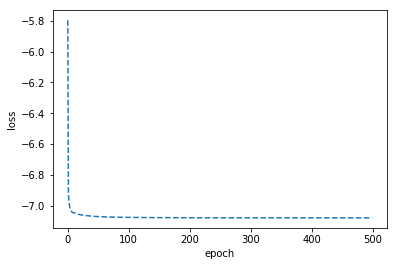

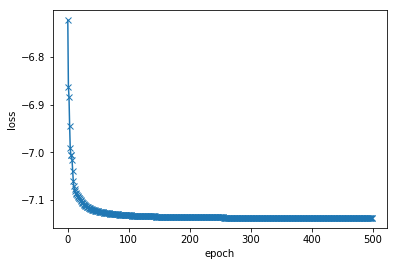

In [16]:
num_epoch = 500
batch_size = 100
clip = 10

losses = []
test_losses = []
k = 0
lrs = [lr]

data_aug = False


for ep_ind in range(1,1+num_epoch):


    #go from 0 to epoch_size in batch_size steps
    #to get completely new data for every batch
    cur_losses = []

    net.train()
    for i in range(0, len(cleaned_train_data_x), batch_size):
        #print(get_batch(i, batch_size))
        np_batch = cleaned_train_data_x[i:i+batch_size,-prev_steps:,:,[0,1]]
        
        if data_aug:
            np_batch[:,:,:,0] = np_batch[:,:,:,0]+1e-7*np.random.randn(np_batch.shape[0],np_batch.shape[1],np_batch.shape[2])
        
        x_batch = Variable(torch.from_numpy(np_batch)).float()
        output = net(x_batch)
        target_batch = Variable(torch.from_numpy(cleaned_train_data_y[i:i+batch_size,:future_steps,:,0]).float()).view(-1, num_pred_steps, len(nodes))
        
        

        batch_loss = criterion(output, target_batch)


        #x_batch = Variable(torch.from_numpy(np_batch[0])).float()
        #output = net(x_batch)
        #target_batch = Variable(torch.from_numpy(np_batch[1]).float())
        #batch_loss = criterion(output[0], target_batch)
        #if k < 100:
        #    print(batch_loss)
        #    k = k + 1

        optimizer.zero_grad()
        batch_loss.backward()
        #nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        cur_losses.append(batch_loss)

    net.eval()
    test_pred = net(torch.from_numpy(cleaned_test_data_x[:,-prev_steps:,:,[0,1]]).float())
    test_target = torch.from_numpy(cleaned_test_data_y[:,:future_steps,:,0,]).float().view(-1, num_pred_steps, len(nodes))
    test_losses.append(criterion(test_pred, test_target))

    losses.append(sum(cur_losses)/len(cur_losses))
    print("epoch is " + str(ep_ind))
    print("cur_loss is " + str(losses[-1]) )
    print("test loss is " + str(test_losses[-1].detach().numpy()[()]))
    plt.plot(np.log(losses), linestyle = '--')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    plt.plot(np.log(test_losses), marker = 'x')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    clear_output(wait=True)

In [17]:
test_pred = net(torch.from_numpy(cleaned_test_data_x[:,-prev_steps:,:,[0,1]]).float())[:,:,0]
test_target = torch.from_numpy(cleaned_test_data_y[:,:future_steps,:,0]).float().view(-1, num_pred_steps, len(nodes))[:,:,0]
criterion(test_pred, test_target).detach().numpy()

array(0.00079477, dtype=float32)

In [18]:
torch.save(test_pred, "jan_fc01_avg_1node13.pt")